# WASP-107

In [1]:
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt

In [2]:
name = 'WASP-107'

In [3]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))
obs = om.Observation.from_files(fnames)

In [4]:
obs

TYC-5530-1795-1 [3 Visits]

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

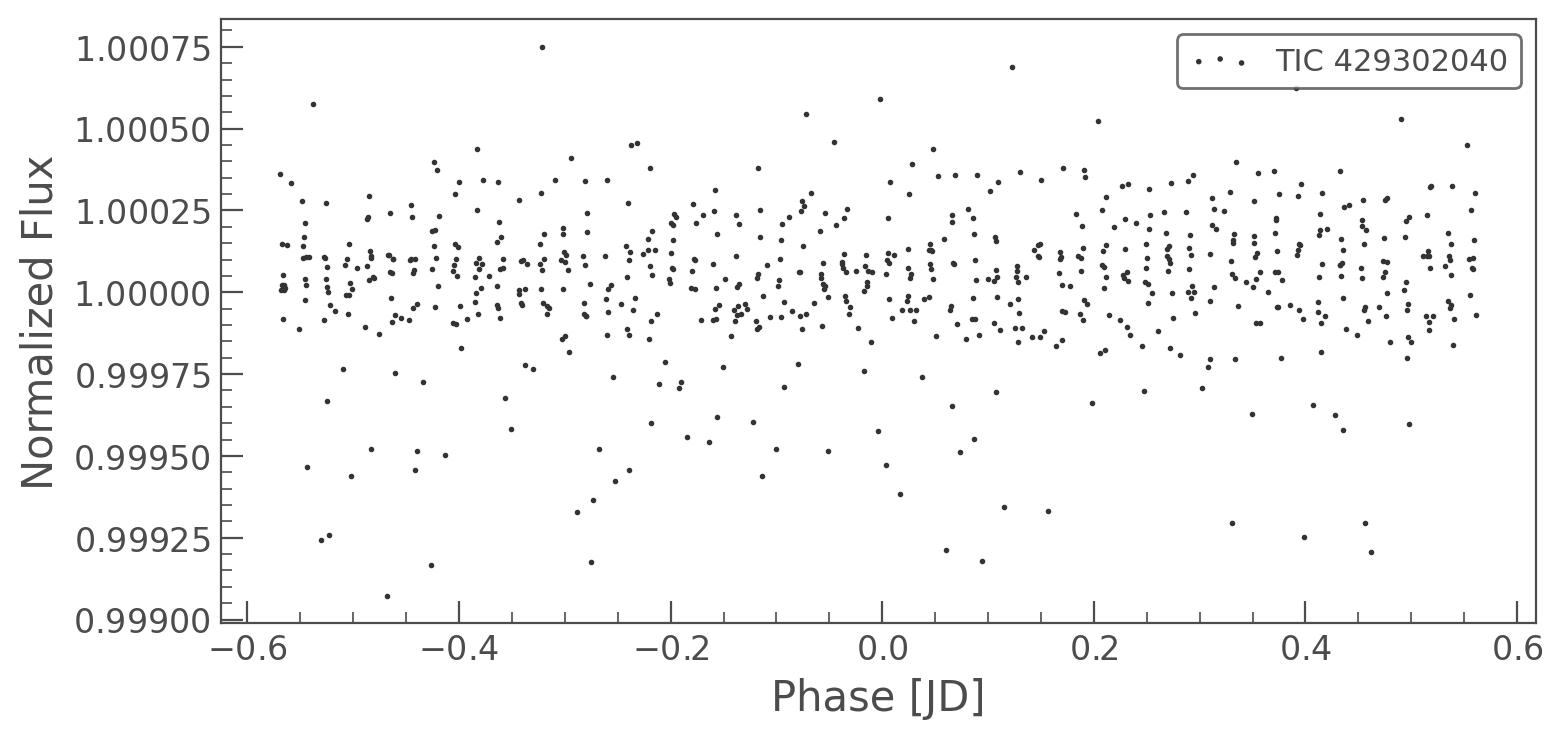

In [5]:
import lightkurve as lk
import astropy.units as u
lcs = lk.LightCurveCollection([lk.search_lightcurve(name, author='K2SFF').download().flatten(201, sigma=2), lk.search_lightcurve(name, author='TESS-SPOC').download().flatten(201, sigma=2)])
clc = lcs.stitch().remove_nans().flatten(1501, sigma=2)
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s
k = np.abs(((clc.time.value - (obs.t0 - 2457000 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1
clc[k].fold(obs.period, obs.t0 - 2457000).scatter()

In [6]:
obs.fit_transit(x_suppl=clc.time.value + 2457000,
                y_suppl=clc.flux.value/np.median(clc.flux.value),
                yerr_suppl=clc.flux_err.value/np.median(clc.flux.value),
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=True, fit_period=True, fit_inc=True)

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

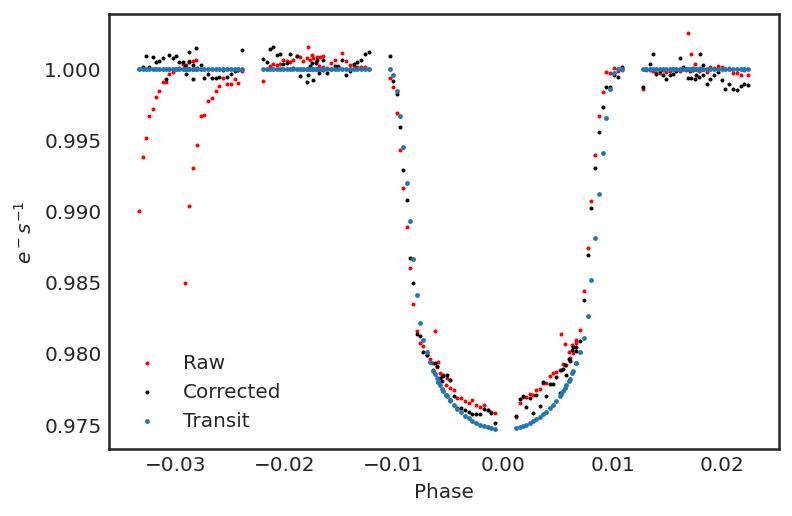

In [7]:
obs.plot()

In [8]:
obs.fit_model()

Fitting Transit/Eclipse Model:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting Transit/Eclipse Model:  33%|███▎      | 1/3 [00:16<00:32, 16.31s/it]

Fitting Transit/Eclipse Model:  67%|██████▋   | 2/3 [00:31<00:15, 15.88s/it]

Fitting Transit/Eclipse Model: 100%|██████████| 3/3 [00:46<00:00, 15.10s/it]

Fitting Transit/Eclipse Model: 100%|██████████| 3/3 [00:46<00:00, 15.35s/it]

<AxesSubplot:title={'center':'TYC-5530-1795-1 Stellar Spectrum'}, xlabel='Wavelength', ylabel='$\\delta$ Transit Depth [ppm]'>

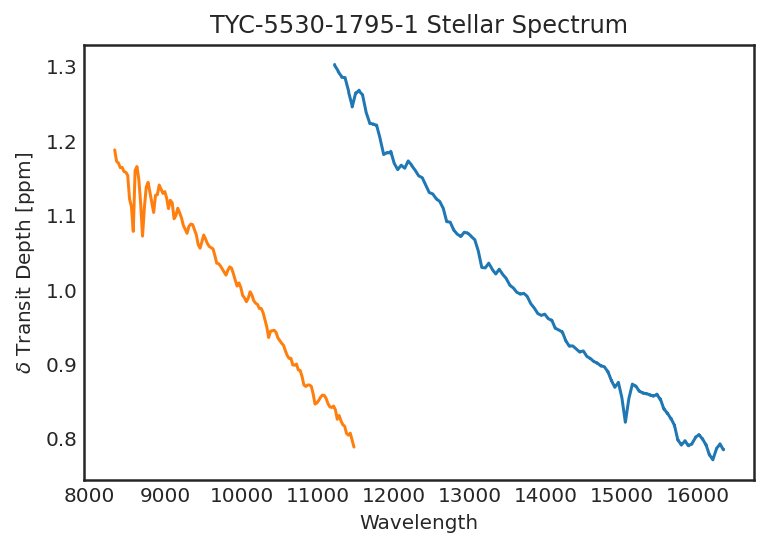

In [9]:
obs.stellar_spectra.plot()

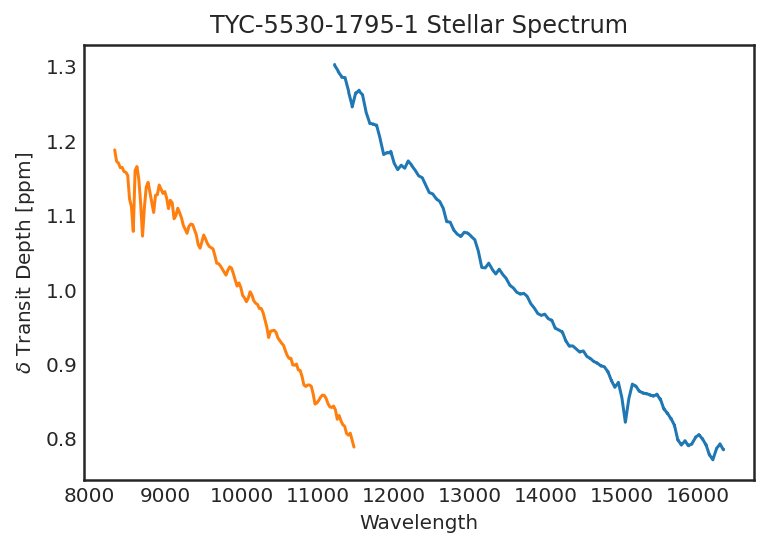

In [10]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

[Text(0.5, 1.0, 'WASP-107 Transmission Spectrum')]

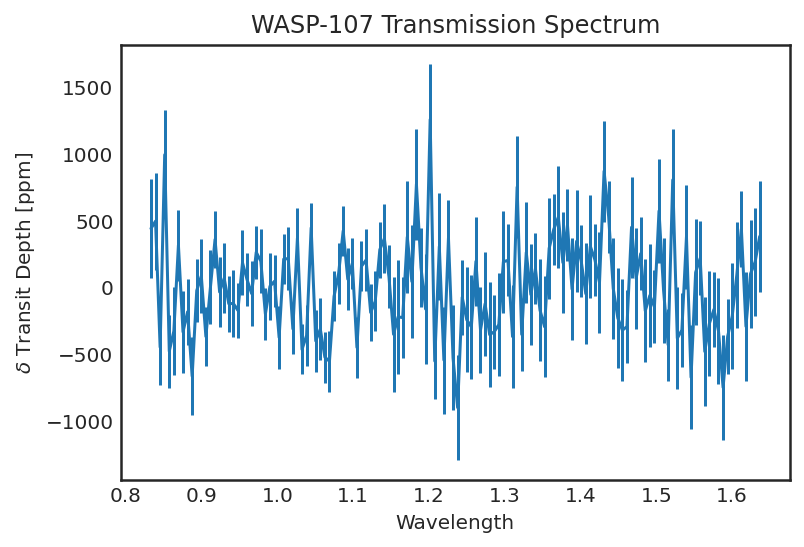

In [11]:
ax = om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 150)).plot()
ax.set(title='WASP-107 Transmission Spectrum')

In [12]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits')
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits')
except:
    pass

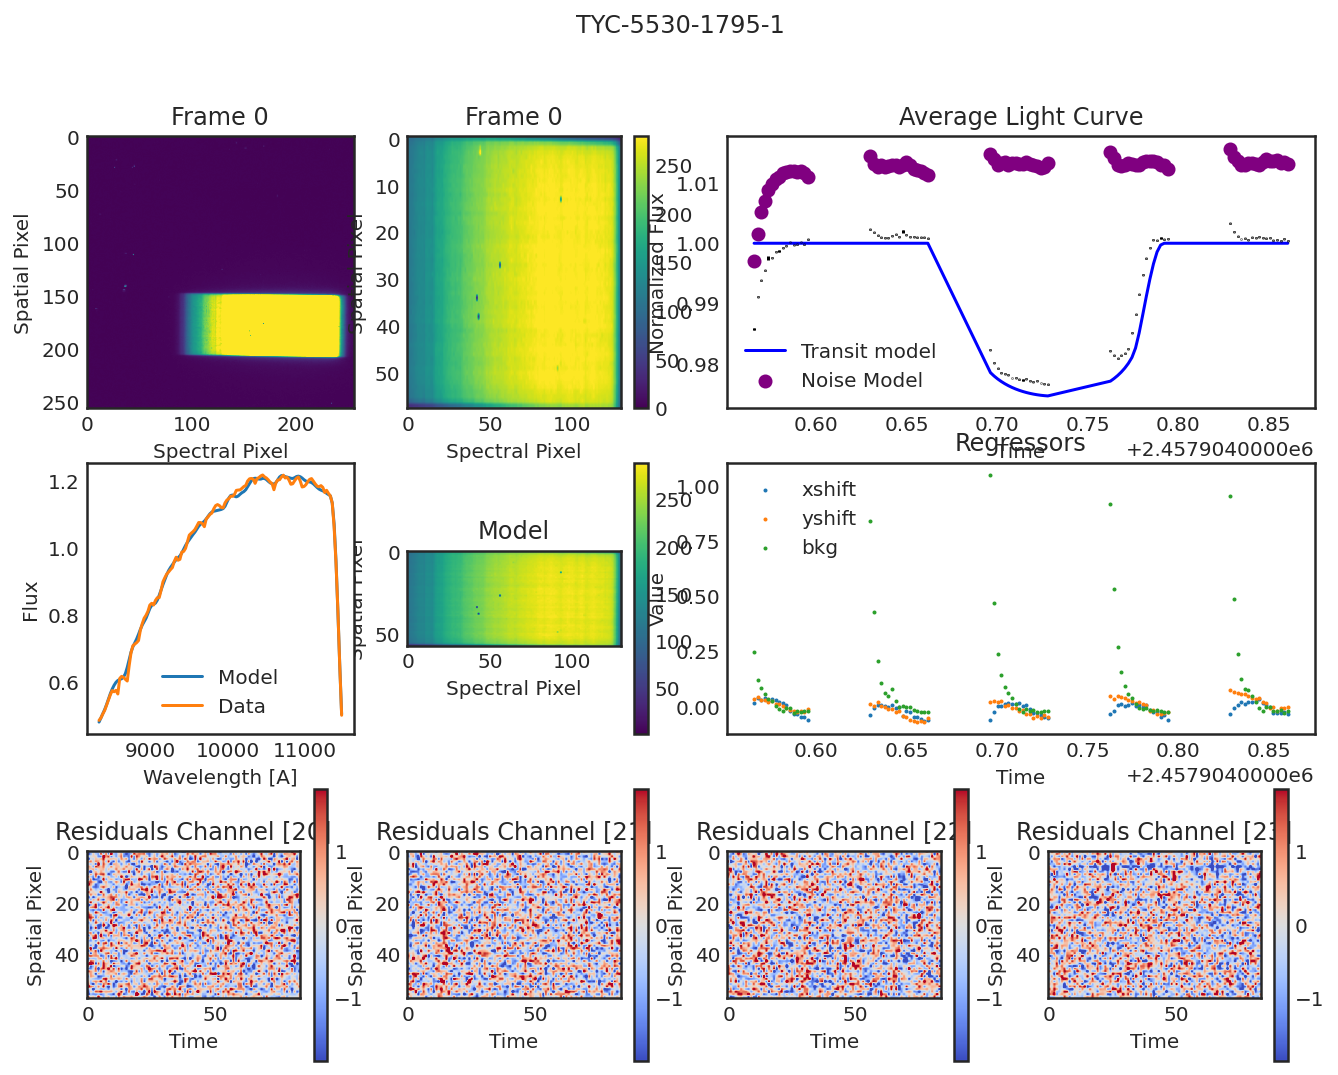

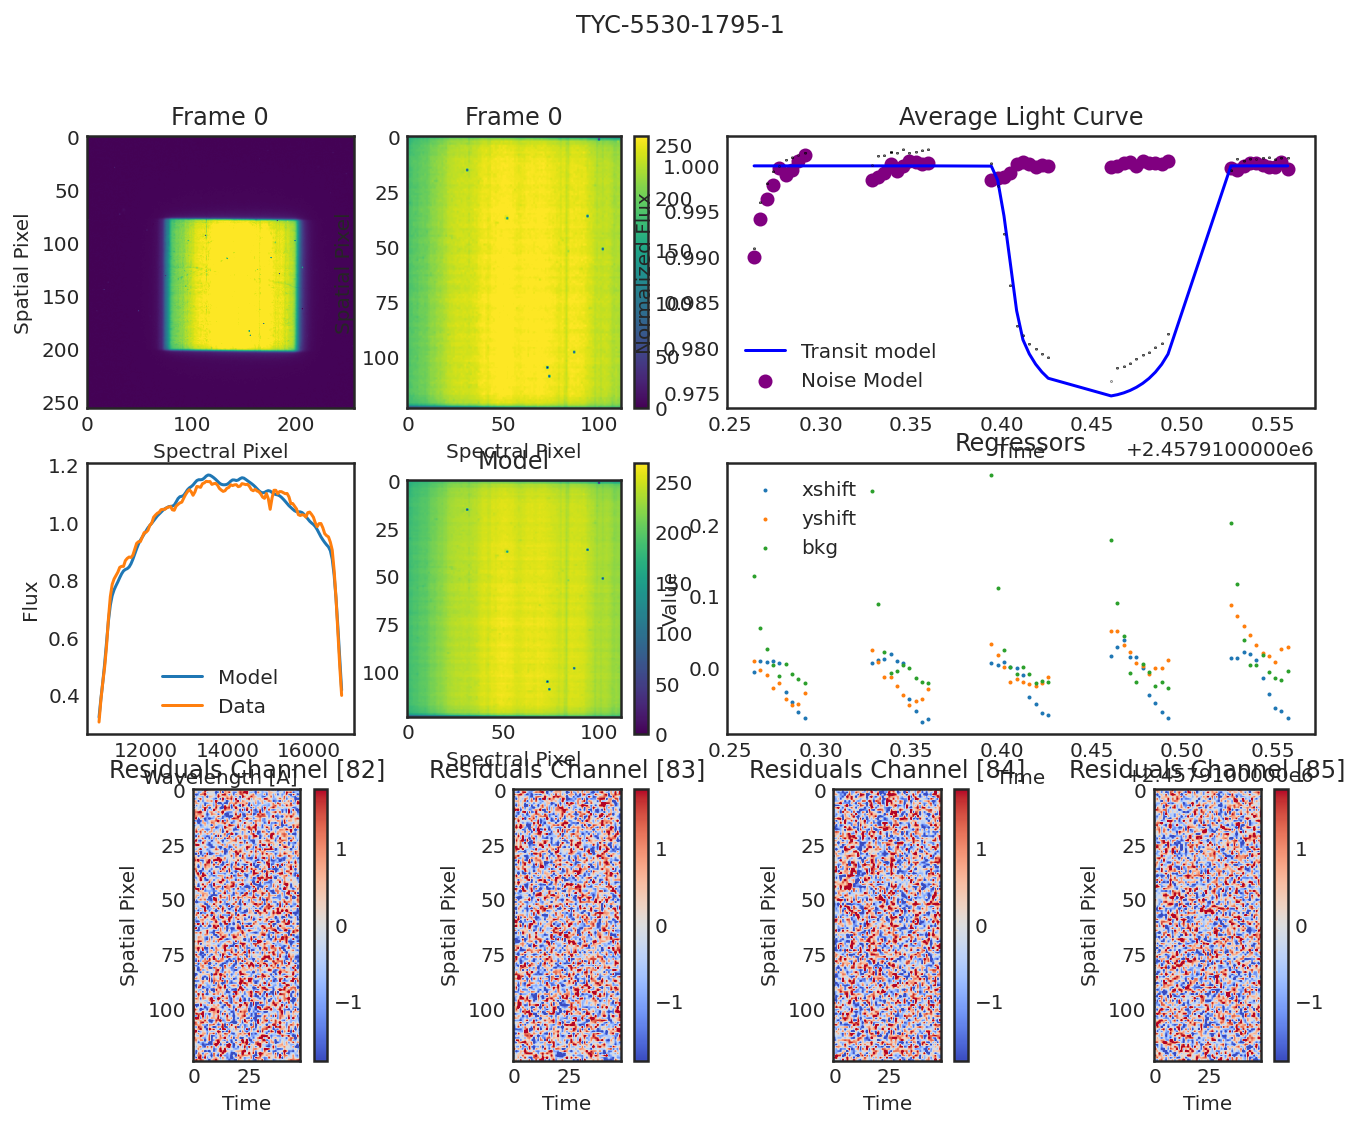

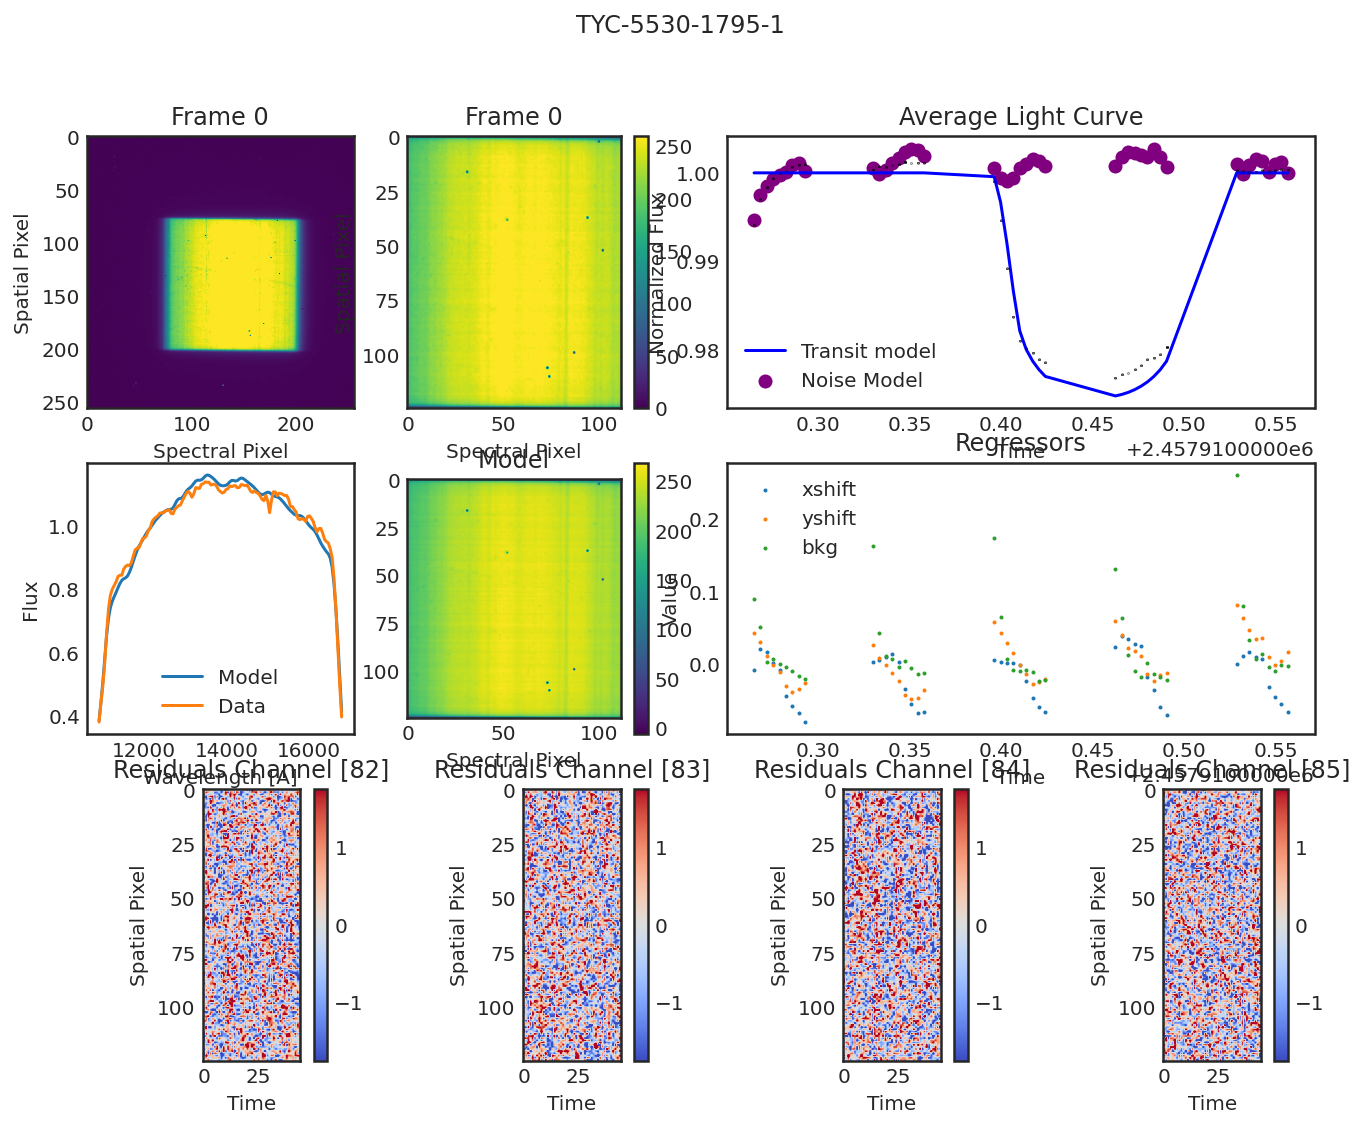

In [13]:
for visit in obs:
    visit.diagnose();
    plt.show();